
## Задача А:

К нам приходят логи поведения пользователей в интернете (по 5 минут). Система логирования достаточно сложная и многоуровневая, плюс сами логи могут быть очень большими. Это приводит к потери части логов, которые потом могут быть догруженны, но с неправильным временем. Нужно выявлять такие аномалии.
У вас есть 2 файла:

    1. data_test.csv - 2 колонки. В первой - время в формате timestamp, во второй - объем логов за 5 минут начиная с секунды указаной в первой колонке. Данные за 1 месяц, гранулярность 5 мин
    
    2. anomaly.csv - 1 колонка. Начало 5 минутного интервала, объем логов в котором считается аномальным. Это результаты ручной разметки группы тестирования. Мы принимаем это за истинну

### Требуется:
    1. Прочитать данные и сформировать датафрейм с идентификатором, признаком (или признаками) и таргетом
    2. Посмотреть базовые статистики распределения количества запросов за 5 минут. Сделать выводы о характере распределения и его особенностях 
    3. Визуализировать данные. Явно показать на графике аномалии
    4. Предложить гипотезы по способу определения аномалий, если возможно - проверить некоторые
    5. Обучить любую модель, которая могла бы находить аномалии в таких данных. Оценить качество полученного решения и потенциал по его улучшению

## Задача В:
На вход приходит список итераторов. 

    1. Самым быстрым способом посчитать количество уникальных элементов во всех итераторах (т.е. надо вернуть 1 число, количество всех уникальных элементов во всех итераторах)    
    2. Сформировать список уникальных элементов из пункт 1 с количествами их встречаемости в исходных итераторах(во всех, а не каждому)
    
    Ниже приведен пример входа для этой задачи. Список итераторов

In [1]:
# то что дано
# Входные данные
import numpy as np
a = [range(10**2),
     ((i*2-8)%100 for i in range(100,2**12,2)),
     ((i+105)%100 for i in range(7**7)),
     np.random.randint(low = 0,high = 100, size = 10**5)]

### add some lybraries (все которые могут понадобится)

In [2]:
import pandas as pd
from scipy import stats as st
import seaborn as sns
import numpy as np
import math as mth
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import datetime as dt
from datetime import datetime, timedelta
from matplotlib.pyplot import figure
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import plotly.graph_objs as go
from collections import Counter
from plotly import graph_objects as go

### Перейдем к базовой предобработке данных 

In [3]:
# открываем все файлы с датой
file_path = '/Users/y.p.alekseeva/Desktop/Test_work_PBD/data_test.csv'

In [4]:
# открываем все файлы с датой
path = '/Users/y.p.alekseeva/Desktop/Test_work_PBD/anomaly.csv' 

In [5]:
logs = pd.read_csv(file_path, sep='\t')

In [6]:
anomaly = pd.read_csv(path)

In [7]:
logs.head()

,timestamp_minutes5,sum_count
0,1559336400,31466984.0
1,1559336700,29108251.0
2,1559337000,28475443.0
3,1559337300,27278641.0
4,1559337600,26539619.0


In [8]:
anomaly.head()

,timestamp_minutes5
0,1559372700
1,1559373000
2,1559373300
3,1559373600
4,1559373900


In [9]:
logs.info()
# читаем инфу по данным, ничего интересного пока, только дата неудобного формата

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7514 entries, 0 to 7513
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp_minutes5  7514 non-null   int64  
 1   sum_count           7514 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 117.5 KB


In [10]:
logs.duplicated().sum()

0

In [11]:
logs.drop_duplicates(inplace=True) 

In [12]:
anomaly.info()
# читаем инфу по данным, ничего интересного пока, только дата неудобного формата 2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   timestamp_minutes5  123 non-null    int64
dtypes: int64(1)
memory usage: 1.1 KB


In [13]:
anomaly.duplicated().sum()

25

In [14]:
anomaly.drop_duplicates(inplace=True) 

In [15]:
 # мержим датафреймы для обработки дальнейшей, ставим 1 при наличии аномалии
logs = logs.merge(anomaly.assign(anomaly=1), on='timestamp_minutes5', how='left')
logs['anomaly'].fillna(0, inplace=True)
logs['anomaly'] = logs['anomaly'].astype('int')

In [16]:
logs.rename(columns={'timestamp_minutes5': 'time'}, inplace=True)
logs.head(10)

,time,sum_count,anomaly
0,1559336400,31466984.0,0
1,1559336700,29108251.0,0
2,1559337000,28475443.0,0
3,1559337300,27278641.0,0
4,1559337600,26539619.0,0
5,1559337900,26135431.0,0
6,1559338200,25033838.0,0
7,1559338500,23503759.0,0
8,1559338800,23214042.0,0
9,1559339100,22845197.0,0


In [17]:
# time was edited to readable user friendly format
logs['time'] = pd.to_datetime(logs['time'], unit='s')

In [18]:
logs.head()

,time,sum_count,anomaly
0,2019-05-31 21:00:00,31466984.0,0
1,2019-05-31 21:05:00,29108251.0,0
2,2019-05-31 21:10:00,28475443.0,0
3,2019-05-31 21:15:00,27278641.0,0
4,2019-05-31 21:20:00,26539619.0,0


***Получили датасет с идентификатором начала 5-минутного интервала, объемом логов за каждый 5-минутный интервал и целевой переменной***

In [19]:
 # базовая статистическая история
logs['sum_count'].describe()

count    7.514000e+03
mean     2.152030e+07
std      8.580380e+06
min      2.184130e+05
25%      1.398447e+07
50%      2.263805e+07
75%      2.775650e+07
max      4.705891e+07
Name: sum_count, dtype: float64

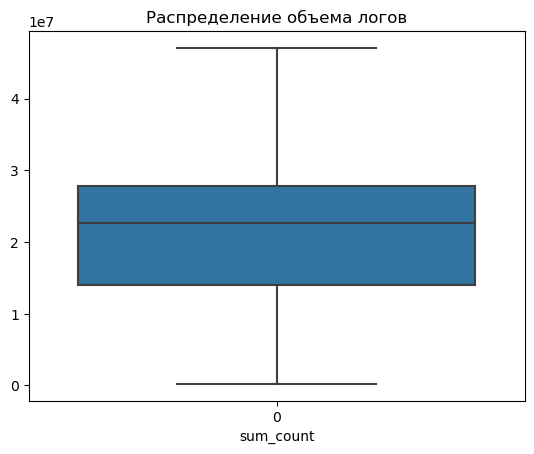

In [20]:
data = logs['sum_count']
sns.boxplot(data)
plt.title('Распределение объема логов')
plt.xlabel('sum_count')
plt.show()

***Что можем сказать?***

- в среднем за 5 минут генерируется около 21.5 миллионов запросов
 - большой разброс данных (судя по стандартному отклонению) и перцентилям
 - 25% всех измерений имеют количество запросов менее 14 миллионов, а 75% всех измерений имеют количество запросов менее 28 миллионов
 - учитывая то, что медиана близка к среднему значению, распределение данных относительно симметрично

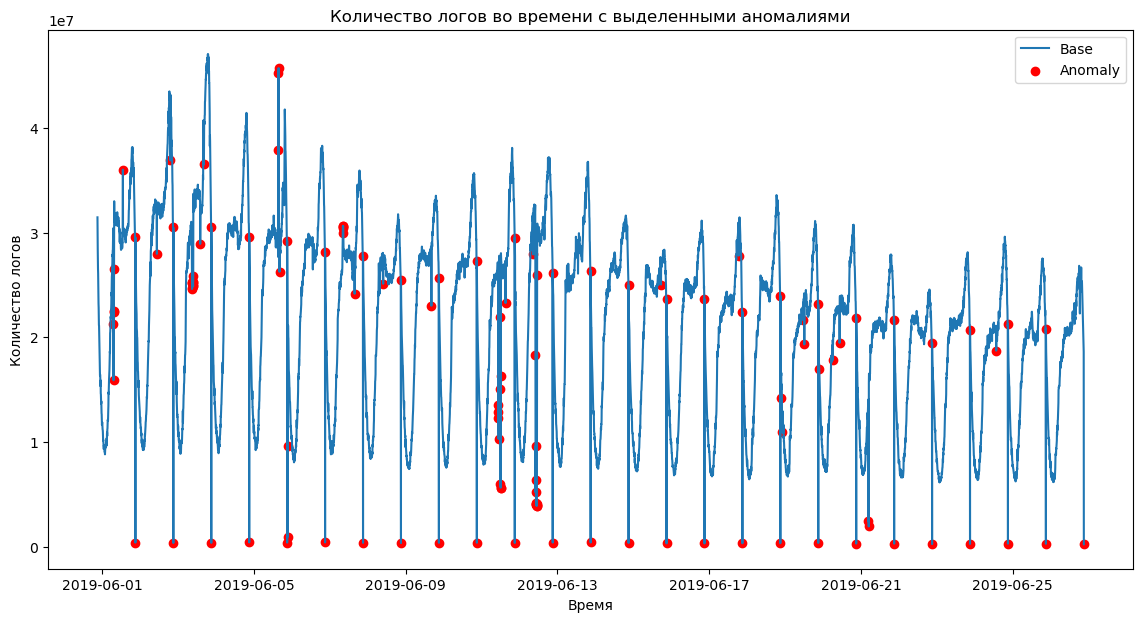

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(logs['time'], logs['sum_count'], label='Base')
plt.scatter(logs[logs['anomaly'] == 1]['time'], logs[logs['anomaly'] == 1]['sum_count'], color='red', label='Anomaly')
plt.title('Количество логов во времени с выделенными аномалиями')
plt.xlabel('Время')
plt.ylabel('Количество логов')
plt.legend()
plt.show()

***График количества логов во времени с выделенными аномалиями показывает:***

- цикличность данных, что может указывать на периодически повторяющуюся активность, связанную с определёнными временными промежутками (например, регулярные задачи в виде ежедневного резервного копирования).
- данные, которые были помечены как аномальные (выходят за общий тренд и представляют значения, сильно отличающиеся от ожидаемых на основании большинства данных)
- существующую волатильность те разброс значений, где пики и спады более выражены, что может указывать на изменение активности или наличие событий, влияющих на генерацию логов.
- пики, особенно высокие тоже показывают высокую активность или кенерацию big data
- наличие трендов, паттернов и сезонности, например, увеличение количества логов к определённым датам или времени года
- если аномалии это не неестественное поведение системы, значит можно ставить гипотезу о наличии возможныых сбоях 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


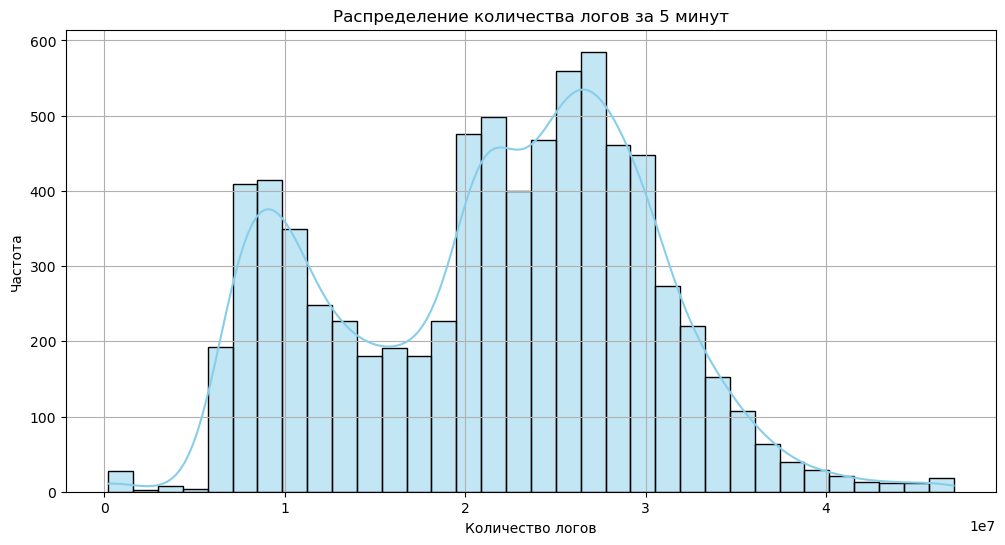

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(logs['sum_count'], kde=True, color="skyblue")
plt.title('Распределение количества логов за 5 минут')
plt.xlabel('Количество логов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

***Что можем сказать***
- По графику видим, что есть два пика, которые могут указывать на два наиболее часто встречающихся значения или группы значений количества логов, однако распределение выглядит относительно симметричным вокруг двух пиков
- можно предположить что есть 2 группы с нормально распределенными значениями
- Существует несколько возможных и существенных выбросов, представленных столбцами на концах гистограммы
- В пределах 1 и 3.5 миллионов логов находится основная часть наблюдений.
- На гистограмме видны несколько столбцов, которые находятся слишком далеко от основной массы данных, что может свидетельствовать об аномалиях

### Определение аномальных значений
- Аномалии могут быть определены, если объем логов за 5 минут значительно отличается от среднего значения, например, выходит за пределы 2-3 стандартных отклонений от среднего.
- Через IQR: аномальными могут считаться значения, выходящие за пределы 1.5 IQR выше третьего квартиля или ниже первого квартиля.
- Сезонные или временные аномалии: те что происходят в необычное время, например, значительный рост активности ночью или значительные изменения в объеме логов по сравнению с предыдущими периодами.

Для проверки этих гипотез можно пойти через стат параметры и метрики (среднее значение и стандартное отклонение для sum_count и определение пороговых значений для аномалий)

In [33]:
# Аномалии могут быть определены, если объем логов за 5 минут значительно отличается от среднего значения, 
# например, выходит за пределы 2-3 стандартных отклонений от среднего.
mean_logs = logs['sum_count'].mean()
std_logs = logs['sum_count'].std()

# наблюдения, которые выходят за пределы 2-3 стандартных отклонений
anomalies_std = logs[(logs['sum_count'] < (mean_logs - 3 * std_logs)) | 
                     (logs['sum_count'] > (mean_logs + 3 * std_logs))]
print(mean_logs)
print(std_logs)
anomalies_std

21520295.106867183
8580379.707961446


,time,sum_count,anomaly,hour


- не видим таких отклонений

In [32]:
# Через IQR: аномальными могут считаться значения, выходящие за пределы 1.5 IQR выше третьего квартиля или ниже первого квартиля.
Q1 = logs['sum_count'].quantile(0.25)
Q3 = logs['sum_count'].quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(Q3)
print(IQR)
# наблюдения, которые выходят за пределы 1.5 IQR 
print(logs[(logs['sum_count'] < (Q1 - 1.5 * IQR))])
print(logs[(logs['sum_count'] > (Q3 + 1.5 * IQR))])

13984467.25
27756499.0
13772031.75
Empty DataFrame
Columns: [time, sum_count, anomaly, hour]
Index: []
Empty DataFrame
Columns: [time, sum_count, anomaly, hour]
Index: []


- снова нет выраженных аномалий, хотя на графике мы их видим, возможно потребуется более детальный анализ с помощью временных рядов

In [36]:
logs['hour'] = logs['time'].dt.hour
night_time = logs[(logs['hour'] >= 0) & (logs['hour'] <= 5)]

# сравним среднее кол-во логов ночью со средним в другое время
mean_night_logs = night_time['sum_count'].mean()
mean_day_logs = logs[(logs['hour'] > 5)]['sum_count'].mean()

print(mean_night_logs)
print(mean_day_logs)

11626480.499465812
24803035.437433533


In [38]:
# значительный рост ночью является аномалией, выведем аномалии
night_anomalies = night_time[night_time['sum_count'] > mean_day_logs]
night_anomalies

,time,sum_count,anomaly,hour
674,2019-06-03 05:00:00,25020486.0,0,5
675,2019-06-03 05:05:00,25988527.0,0,5
676,2019-06-03 05:10:00,26176991.0,0,5
677,2019-06-03 05:15:00,26148082.0,0,5
678,2019-06-03 05:20:00,26357438.0,0,5
679,2019-06-03 05:25:00,26272235.0,0,5
680,2019-06-03 05:30:00,26593123.0,0,5
681,2019-06-03 05:35:00,26666536.0,0,5
682,2019-06-03 05:40:00,26554771.0,0,5
683,2019-06-03 05:45:00,27161082.0,0,5


Действительно видим ночные аномалии, но более детальнй анализ временных рядов помог бы сделать это чуть более аккуратно

## Model

In [28]:
from sklearn.ensemble import IsolationForest # используется для поиска аномалий 
from sklearn.metrics import classification_report, accuracy_score

X = logs[['sum_count']]
y_true = logs['anomaly']

# cоздаем модель и обучим
model = IsolationForest(n_estimators=100, contamination='auto')
model.fit(X)

y_pred = model.predict(X)
# 0 (норма), 1 (аномалия)
y_pred = [0 if x == 1 else 1 for x in y_pred]

# оценка качества модели
print(classification_report(y_true, y_pred))
print("Accuracy Score:", accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.70      0.82      7391
           1       0.03      0.46      0.05       123

    accuracy                           0.70      7514
   macro avg       0.51      0.58      0.43      7514
weighted avg       0.97      0.70      0.81      7514

Accuracy Score: 0.6985626829917487


***Что можем сказать***
- Точность для нормальных наблюдений очень высока и составляет 99%, что указывает на то, что модель очень хорошо определяет нормальные случаи, но не можем сказать это же про аномалии, тут точность хромает и возможно они и не являются аномалиями
-  Модель не смогла идентифицировать около трети нормальных наблюдений, ошибочно отнесла их к аномальным (или наоборот). Для аномальных наблюдений полнота составляет 46%, что означает, что модель смогла правильно идентифицировать почти половину всех аномалий
- F1 для нормальных наблюдений 0.80, что является хорошим результатом, но для аномальных наблюдений всего 0.04, что указывает на очень плохую эффективность модели в определении аномалий
- Общая точность модели составляет 67.1%, что может показаться приемлемым результатом, но в контексте сильно несбалансированных групп(7391 против 123) не доказывает эффективность модели

#### Что можем улучшить:

- настроить гиперпараметры : количество параметров n_estimators и пороговое значение contamination, что значительно может улучшить результаты
- добавить доп признаки если они будут в доступе, для более точной работы модели
- использовать другие модели и подходы для проверки и фиксирования наилучшей для большей точности, и увеличения fit the data


### Part B
#### Количество уникальных элементов во всех итераторах и список уникальных элементов из пункт 1 с количествами их встречаемости в исходных итераторах


In [29]:
# из Дано
a = [range(10**2),
     ((i*2-8)%100 for i in range(100,2**12,2)),
     ((i+105)%100 for i in range(7**7)),
     np.random.randint(low=0, high=100, size=10**5)]

all_elements = [] # просто список всех итераторов получаем циклом
for iterator in a:
    all_elements.extend(list(iterator))

# количество уникальных элементов
unique_elements = set(all_elements) # идем через множество
print(f'Количество уникальных элементов: {len(unique_elements)}')

Количество уникальных элементов: 100


In [30]:
# список уникальных элементов из пункт 1 с количествами их встречаемости в исходных итераторах¶
elements_count = Counter(all_elements)
print(f'Список уникальных элементов с количествами их встречаемости: {elements_count}')

Список уникальных элементов с количествами их встречаемости: Counter({40: 9362, 28: 9340, 24: 9337, 64: 9335, 52: 9332, 95: 9331, 8: 9327, 20: 9320, 21: 9316, 60: 9316, 92: 9315, 84: 9314, 12: 9312, 80: 9312, 0: 9306, 97: 9305, 4: 9304, 88: 9297, 10: 9295, 63: 9293, 32: 9288, 50: 9287, 76: 9284, 47: 9283, 44: 9282, 55: 9281, 87: 9281, 18: 9280, 48: 9278, 7: 9277, 56: 9277, 89: 9272, 96: 9271, 26: 9268, 36: 9268, 19: 9265, 1: 9263, 34: 9263, 46: 9262, 68: 9262, 59: 9261, 91: 9261, 31: 9260, 72: 9260, 86: 9260, 99: 9260, 75: 9259, 79: 9259, 58: 9258, 22: 9256, 78: 9256, 67: 9255, 16: 9253, 17: 9253, 65: 9253, 41: 9252, 13: 9249, 33: 9249, 43: 9247, 66: 9247, 11: 9245, 15: 9245, 9: 9244, 29: 9243, 35: 9243, 62: 9243, 38: 9242, 27: 9239, 70: 9236, 69: 9235, 73: 9232, 61: 9230, 37: 9229, 98: 9229, 57: 9228, 94: 9228, 30: 9227, 83: 9227, 51: 9223, 3: 9221, 42: 9221, 2: 9220, 5: 9219, 25: 9218, 6: 9214, 90: 9214, 93: 9214, 39: 9210, 77: 9205, 53: 9200, 74: 9194, 85: 9193, 45: 9191, 49: 9191, 